In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
# 1.preprocessing data
# 2.build model
# 2.1 encoder
# 2.2 attention
# 2.3 decoder
# 2.4 loss & optimizer
# 2.5 train
# 3. evaluation
# 3.1 given sentence,return translated results
# 3.2 visualize results (attention)

In [3]:
en_spa_file_path = './spa.txt'
import unicodedata
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c)!='Mn')

en_sentence = u"May I borrow this book?"
sp_sentence = u"Tomátelo con soda."
print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))

May I borrow this book?
Tomatelo con soda.


In [4]:
import re
def preprocess_sentence(s):
    s = unicode_to_ascii(s.lower().strip())
    # 标点符号前后加空格
    s = re.sub(r"([?.!,¿])",r" \1 ",s)
    # 多余空格变一个空格 
    s = re.sub(r'[" "]+'," ",s)
    # 除了标点符号和字母外都是空格
    s = re.sub(r'[^a-zA-Z?.!,¿]',' ',s)
    # 去掉前后空格
    s = s.rstrip().strip()
    s = '<start> '+s+ ' <end>'
    return s
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))

<start> may i borrow this book ? <end>
<start> tomatelo con soda . <end>


In [5]:
def perse_data(filename):
    lines = open(filename,encoding='UTF-8').read().strip().split('\n')
    sentence_pairs = [line.split('\t') for line in lines ]
    preprocessed_sentence_pairs = [
        (preprocess_sentence(en),preprocess_sentence(sp)) for en,sp in sentence_pairs ]
    return zip(*preprocessed_sentence_pairs)
en_dataset,sp_dataset =  perse_data(en_spa_file_path)
print(en_dataset[-1])
print(sp_dataset[-1])
print(type(en_dataset))

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>
<class 'tuple'>


In [6]:
a = [(1,2),(3,4),(5,6)]
c, d = zip(*a)
print(c,d)

(1, 3, 5) (2, 4, 6)


In [7]:
def tokenizer(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(num_words=None,filters='',split=' ')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    # maxlen=None 默认序列的最大长度
    tensor = keras.preprocessing.sequence.pad_sequences(tensor,padding = 'post')
    return tensor ,lang_tokenizer
input_tensor,input_tokenizer = tokenizer(sp_dataset[0:30000])
output_tensor,output_tokenizer = tokenizer(en_dataset[0:30000])

def max_length(tensor):
    return max(len(t) for t in tensor)
max_length_input = max_length(input_tensor)
max_length_output = max_length(output_tensor)
print(input_tensor.shape)
print(output_tensor.shape)
print(max_length_input,max_length_output)

(30000, 16)
(30000, 11)
16 11


In [8]:
from sklearn.model_selection import train_test_split
input_train,input_eval,output_train,output_eval = train_test_split(input_tensor,output_tensor,test_size = 0.2)
len(input_train),len(input_eval),len(output_train),len(output_eval)

(24000, 6000, 24000, 6000)

In [9]:
def convert(example,tokenizer):
    for t in example:
        if t != 0:
            print('%d -->%s'%(t,tokenizer.index_word[t]))
convert(input_train[0],input_tokenizer)
print()
convert(output_train[0],output_tokenizer)

1 --><start>
12 -->me
40 -->gusta
163 -->ver
13 -->la
248 -->television
3 -->.
2 --><end>

1 --><start>
4 -->i
35 -->like
408 -->watching
215 -->tv
3 -->.
2 --><end>


In [10]:
def make_dataset(input_tensor,output_tensor,batch_size,epochs,shuffle):
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor,output_tensor))
    if shuffle:
        dataset = dataset.shuffle(30000)
    dataset = dataset.repeat(epochs).batch(batch_size,drop_remainder = True)
    return dataset
batch_size =64
epochs =20
train_dataset = make_dataset(input_train,output_train,batch_size,epochs,True)
eval_dataset = make_dataset(input_eval,output_eval,batch_size,1,False)

In [11]:
embedding_units = 256
units = 1024
# 字典长度加1  为补齐的0向量
input_vocab_size = len(input_tokenizer.word_index)+1
output_vocab_size = len(output_tokenizer.word_index)+1

In [12]:
for x,y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)

(64, 16)
(64, 11)


In [13]:
class Encoder(keras.Model):
    def __init__(self,vocab_size,embedding_units,encoding_units,batch_size):
        super(Encoder,self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size,embedding_units)
        self.gru = keras.layers.GRU(self.encoding_units,
                                    return_sequences = True,
                                    return_state = True,
                                    recurrent_initializer = 'glorot_uniform')
    def call(self,x,hidden):
        x = self.embedding(x)
        output,state = self.gru(x,initial_state = hidden)
        return output,state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size,self.encoding_units))
encoder = Encoder(input_vocab_size,embedding_units,units,batch_size)
sample_hidden = encoder.initialize_hidden_state()
# return_sequence返回每个时间步上的隐状态（hidden state），return_state返回最后一个时间步上细胞状态（cell state）
sample_output,sample_hidden = encoder(x,sample_hidden)
print("sample_output.shape:",sample_output.shape)
print("sample_hidden.shape:",sample_hidden.shape)

sample_output.shape: (64, 16, 1024)
sample_hidden.shape: (64, 1024)


In [14]:
class BahdanauAttention(keras.Model):
    def __init__(self,units):
        super(BahdanauAttention,self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
    def call(self,decoder_hidden,encoder_outputs):
        # decoder_hidden.shape: (bath_size,units)
        # encoder_outputs.shape: (batch_size,length,units)
        # 维度扩展 ecoder_hidden.shape: (bath_size,1，units)
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden,1)
        # before V: (batch_size,length.units)
        # ather V: (batch_size,length,1)
        # print(self.W1(encoder_outputs).shape)  (64, 16, 10)
        # print(self.W2(decoder_hidden_with_time_axis).shape)   (64, 1, 10)
        score = self.V(tf.nn.tanh(self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)))
        # print(score.shape) (64, 16, 1)
        # shape: (batch_size,length,1)
        attention_weights = tf.nn.softmax(score,axis = 1)
        # context_vector (batch_size,length,units)
        context_vector = attention_weights * encoder_outputs
        # context_vector.shape: (batch_size,units)
        context_vector = tf.reduce_sum(context_vector,axis =1 )
        return context_vector,attention_weights
# 测试
attention_model = BahdanauAttention(units = 10)
attention_results,attention_weights = attention_model(sample_hidden,sample_output)
print("attention_results.shape:",attention_results.shape)
print("attention_weights.shape:",attention_weights.shape)

attention_results.shape: (64, 1024)
attention_weights.shape: (64, 16, 1)


In [15]:
class Decoder(keras.Model):
    def __init__(self,vocab_size,embedding_dim,decoding_units,batch_size):
        super(Decoder,self).__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size,embedding_units)
        self.gru = keras.layers.GRU(self.decoding_units,
                                    return_sequences= True,
                                    return_state = True,
                                    recurrent_initializer = 'glorot_uniform')
        self.fc = keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.decoding_units)
    def call(self,x,hidden,encoding_outputs):
        # context_vector.shape: (batch_size,units)
        context_vector,attention_weights = self.attention(hidden,encoding_outputs)
        # x 为单词
        # before embedding : x.shape: (batch_size,1)
        # after embedding : x.shape: (batch_size,1,embedding_units)
        x = self.embedding(x)
        combined_x = tf.concat([tf.expand_dims(context_vector,1),x],axis=-1)
        # print(combined_x.shape)  (64, 1, 1280)  1024+256
        # output.shape: [batch_size,1,decoding_units]
        # state.shape : [batch_size,decoding_units]
        output,state = self.gru(combined_x)
        # output.shape: [batch_size,decoding_units]
        output = tf.reshape(output,(-1,output.shape[2]))
        # output.shape: [batch_size,vocab_size]
        output = self.fc(output)
        return output,state,attention_weights

decoder = Decoder(output_vocab_size,embedding_units,units,batch_size)
outputs = decoder(tf.random.uniform((batch_size,1)),sample_hidden,sample_output)
decoder_output,decoder_hidden,decoder_aw = outputs
print("decoder_output.shape:",decoder_output.shape)
print("decoder_hidden.shape:",decoder_hidden.shape)
print("decoder_aw.shape",decoder_aw.shape)

decoder_output.shape: (64, 4935)
decoder_hidden.shape: (64, 1024)
decoder_aw.shape (64, 16, 1)


In [16]:
optimizer = keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')

def loss_function(real,pred):
    # targ很多padding为0的部分 将这些部分不加入损失函数计算
    mask = tf.math.logical_not(tf.math.equal(real,0))
    # 计算出每个targ对应的损失
    loss_ = loss_object(real,pred)
    mask = tf.cast(mask,dtype=loss_.dtype)
    loss_ *= mask
    print(loss_)
    return tf.reduce_mean(loss_)

In [17]:
y_true = [1]
y_pred = [[0.1, 0.8, 0.1]]
loss_v = loss_object(y_true,y_pred)
print(loss_v)

tf.Tensor([0.6897267], shape=(1,), dtype=float32)


In [18]:
loss_function(y_true,y_pred)

tf.Tensor([0.6897267], shape=(1,), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.6897267>

In [19]:
@tf.function
def train_step(inp,targ,encoding_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden = encoder(inp,encoding_hidden)
        decoding_hidden = encoding_hidden 
        # eg: <start> I am here <end>
        # 1. <start> -> I
        # 2. I -> am
        # 3. am -> here
        # 4. here -> <end>
        for t in range(0,targ.shape[1]-1):
            decoding_input = tf.expand_dims(targ[:,t],1)
            predictions,decoding_hidden, _ = decoder(decoding_input,decoding_hidden,encoding_outputs)
            loss += loss_function(targ[:,t+1],predictions)
    # 计算平均的损失函数
    batch_loss = loss /int(targ.shape[0])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss,variables)
    optimizer.apply_gradients(zip(gradients,variables))
    return batch_loss

In [20]:
import time
epochs = 1
steps_per_epoch = len(input_tensor) // batch_size
for epoch in range(epochs):
    start = time.time()
    encoding_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch,(inp,targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp,targ,encoding_hidden)
        total_loss += batch_loss
        
        if batch%100 ==0:
            print('Epoch{} Batch{} Loss{:.4f}'.format(epoch+1,batch,batch_loss.numpy()))
    print('Epoch{} Loss{:.4f}'.format(epoch+1,total_loss/steps_per_epoch))
    print('Time take for epoch{} sec\n'.format(time.time()-start))

Tensor("mul:0", shape=(64,), dtype=float32)
Tensor("mul_1:0", shape=(64,), dtype=float32)
Tensor("mul_2:0", shape=(64,), dtype=float32)
Tensor("mul_3:0", shape=(64,), dtype=float32)
Tensor("mul_4:0", shape=(64,), dtype=float32)
Tensor("mul_5:0", shape=(64,), dtype=float32)
Tensor("mul_6:0", shape=(64,), dtype=float32)
Tensor("mul_7:0", shape=(64,), dtype=float32)
Tensor("mul_8:0", shape=(64,), dtype=float32)
Tensor("mul_9:0", shape=(64,), dtype=float32)
Tensor("mul:0", shape=(64,), dtype=float32)
Tensor("mul_1:0", shape=(64,), dtype=float32)
Tensor("mul_2:0", shape=(64,), dtype=float32)
Tensor("mul_3:0", shape=(64,), dtype=float32)
Tensor("mul_4:0", shape=(64,), dtype=float32)
Tensor("mul_5:0", shape=(64,), dtype=float32)
Tensor("mul_6:0", shape=(64,), dtype=float32)
Tensor("mul_7:0", shape=(64,), dtype=float32)
Tensor("mul_8:0", shape=(64,), dtype=float32)
Tensor("mul_9:0", shape=(64,), dtype=float32)
Epoch1 Batch0 Loss0.8076
Epoch1 Batch100 Loss0.3984
Epoch1 Batch200 Loss0.3093
Epoch

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline
def evaluate(input_sentence):
    attention_matrix = np.zeros((max_length_output,max_length_input))
    input_sentence = preprocess_sentence(input_sentence)
    
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences([inputs],maxlen = max_length_input,padding= 'post')
    inputs = tf.convert_to_tensor(inputs)
    
    results = ''
    # encoding_hidden = encoder.initialize_hidden_state()
    encoding_hidden = tf.zeros((1,units))
    encoding_outputs ,encoding_hidden = encoder(inputs,encoding_hidden)
    decoding_hidden = encoding_hidden
    
    # eg: <start> -> A
    # A -> B -> C-> D
    
    # decoding_input.shape: (1,1)
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']],0)
    
    for t in range(max_length_output):
        predictions,decoding_hidden,attention_weights = decoder(decoding_input,decoding_hidden,encoding_outputs)
        # attention_weights.shape: (batch_size,input_length,1) (1,16,1)
        # 存储注意力权重以便后面制图
        attention_weights = tf.reshape(attention_weights,(-1,))
        attention_matrix[t] = attention_weights.numpy()
        
        # predictions.shape:(batch_size,vocab_size)  (1,4935)
        print("...",predictions[0])
        print("re..",tf.reduce_max(predictions[0]))
        predicted_id = tf.argmax(predictions[0]).numpy()
        results += output_tokenizer.index_word[predicted_id]+ ' '
        if output_tokenizer.index_word[predicted_id] == '<end>':
            return results,input_sentence,attention_matrix
        # 上一步的输出是下一步的输入
        decoding_input = tf.expand_dims([predicted_id],0)
    return results,inputs,input_sentence,attention_matrix

def plot_attention(attention_matrix,input_sentence,predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    ax.matshow(attention_matrix,cmap='viridis')
    
    font_dict = {'fontsize':14}
    ax.set_xticklabels(['']+input_sentence,fontdict = font_dict,rotation = 90 )
    ax.set_yticklabels(['']+predicted_sentence,fontdict = font_dict,)
    plt.show()

def translate(input_sentence):
    results,input_sentence,attention_matrix = evaluate(input_sentence)
    print("Input:%s"%(input_sentence))
    print("Predicted translation:%s"%(results))
    attention_matrix = attention_matrix[:len(results.split(' ')),:len(input_sentence.split(' '))]
    plot_attention(attention_matrix,input_sentence.split(' '),results.split(' '))

... tf.Tensor(
[-4.586863   -4.5081024   0.43373042 ... -4.6790557  -4.671134
 -4.931502  ], shape=(4935,), dtype=float32)
re.. tf.Tensor(9.563461, shape=(), dtype=float32)
... tf.Tensor([-6.898451  -6.8554425  1.6343931 ... -7.064906  -7.2085648 -7.4278092], shape=(4935,), dtype=float32)
re.. tf.Tensor(6.850647, shape=(), dtype=float32)
... tf.Tensor([-6.5018945 -6.3931174 -1.7796676 ... -6.6280036 -7.03402   -7.0374756], shape=(4935,), dtype=float32)
re.. tf.Tensor(5.5371943, shape=(), dtype=float32)
... tf.Tensor([-6.159809  -6.390952   0.2773208 ... -6.6240463 -6.5951724 -6.956583 ], shape=(4935,), dtype=float32)
re.. tf.Tensor(8.362355, shape=(), dtype=float32)
... tf.Tensor([-4.6508946 -4.809359  17.546335  ... -5.344222  -5.0374603 -4.9174595], shape=(4935,), dtype=float32)
re.. tf.Tensor(17.546335, shape=(), dtype=float32)
Input:<start> ¿ todavia estan en casa ? <end>
Predicted translation:is this one ? <end> 


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator


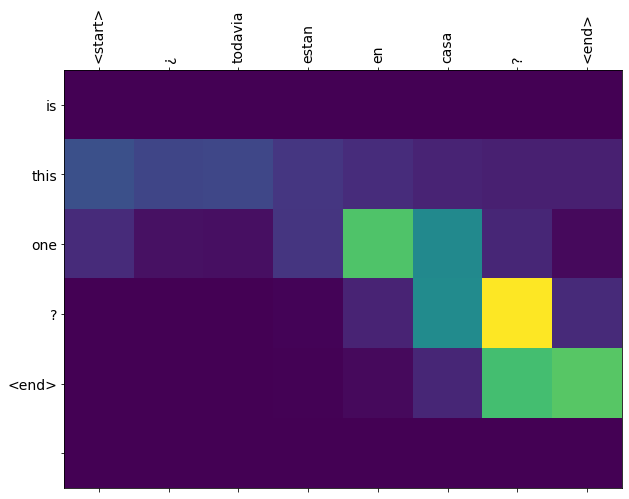

In [22]:
translate(u'¿todavia estan en casa?')